In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from matplotlib import tri

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'iframe'

In [2]:
# !wget https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.e
# !wget https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.v

In [3]:
def generate_quadratic(V, E, return_edges=False):
    """Generate a quadratic element list by adding midpoints to each edge.
    Parameters
    ----------
    V : ndarray
        nv x 2 list of coordinates
    E : ndarray
        ne x 3 list of vertices
    return_edges : bool
        indicate whether list of the refined edges is returned
    Returns
    -------
    V2 : ndarray
        nv2 x 2 list of coordinates
    E2 : ndarray
        ne2 x 6 list of vertices
    Edges : ndarray
        ned x 2 list of edges where the midpoint is generated
    Notes
    -----
        - midpoints are introduced and globally numbered at the end of the vertex list
        - the element list includes the new list beteen v0-v1, v1-v2, and v2-v0
    Examples
    --------
    >>> import numpy as np
    >>> from pyamg.gallery import fem
    >>> V = np.array([[0.,0.], [1.,0.], [0.,1.], [1.,1.]])
    >>> E = np.array([[0,1,2], [2,3,1]])
    >>> V2, E2 = fem.generate_quadratic(V, E)
    >>> print(V2)
    [[0.  0. ]
     [1.  0. ]
     [0.  1. ]
     [1.  1. ]
     [0.5 0. ]
     [0.5 0.5]
     [0.  0.5]
     [0.5 1. ]
     [1.  0.5]]
    >>> print(E2)
    [[0 1 2 4 5 6]
     [2 3 1 7 8 5]]
    """
    if not isinstance(V, np.ndarray) or not isinstance(E, np.ndarray):
        raise ValueError('V and E must be ndarray')

    if V.shape[1] != 2 or E.shape[1] != 3:
        raise ValueError('V should be nv x 2 and E should be ne x 3')

    ne = E.shape[0]

    # make a vertext-to-vertex graph
    ID = np.kron(np.arange(0, ne), np.ones((3,), dtype=int))
    G = sparse.coo_matrix((np.ones((ne*3,), dtype=int), (E.ravel(), ID,)))
    V2V = G * G.T

    # from the vertex graph, get the edges and create new midpoints
    V2Vmid = sparse.tril(V2V, -1)
    Edges = np.vstack((V2Vmid.row, V2Vmid.col)).T
    Vmid = (V[Edges[:, 0], :] + V[Edges[:, 1], :]) / 2.0
    V = np.vstack((V, Vmid))

    # enumerate the new midpoints for the edges
    # V2Vmid[i,j] will have the new number of the midpoint between i and j
    maxindex = E.max() + 1
    newID = maxindex + np.arange(Edges.shape[0])
    V2Vmid.data = newID
    V2Vmid = V2Vmid + V2Vmid.T

    # from the midpoints, extend E
    E = np.hstack((E, np.zeros((E.shape[0], 3), dtype=int)))
    E[:, 3] = V2Vmid[E[:, 0], E[:, 1]]
    E[:, 4] = V2Vmid[E[:, 1], E[:, 2]]
    E[:, 5] = V2Vmid[E[:, 2], E[:, 0]]

    if return_edges:
        return V, E, Edges

    return V, E

In [4]:
def applybc(A, b, V, E):
    """
    Applied zero Dirichlet conditions everywhere

    Returns
    -------
    A : sparse matrix
        Modified, assembled sparse matrix
    b : ndarray
        Modified, assembled right-hand side
    """
    tol = 1e-14
    id1 = np.where(abs(Y+1) < tol)[0]
    id2 = np.where(abs(Y-1) < tol)[0]
    id3 = np.where(abs(X+1) < tol)[0]
    id4 = np.where(abs(X-1) < tol)[0]
    I = np.vstack((id1, id2, id3, id4)).ravel()
    I = np.unique(I)
    Dflag = np.zeros(len(A.data), dtype=bool)
    Dflag[I] = True

    for k, (i, j) in enumerate(zip(A.row, A.col)):
        if Dflag[i] or Dflag[j]:
            if i == j:
                A.data[k] = 1.0
            else:
                A.data[k] = 0.0

    return A, b

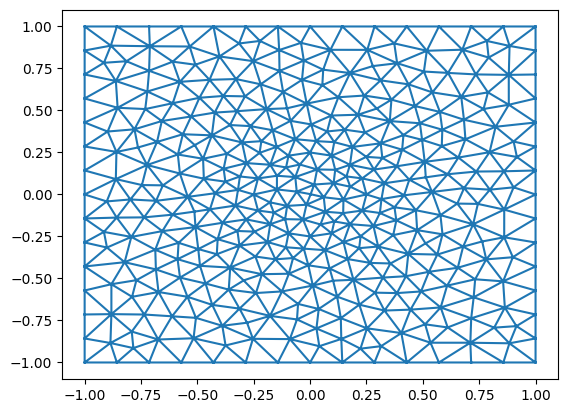

In [5]:
V = np.loadtxt('mesh.v')
E = np.loadtxt('mesh.e', dtype=int)

V2, E2, edges2 = generate_quadratic(V, E, return_edges=True)

X, Y = V2[:, 0], V2[:, 1]
plt.triplot(X, Y, E2[:, :3])

In [6]:
def kappa(x, y):
    if np.sqrt(x**2 + y**2) <= 0.25:
        return 100.0
    return 2.0

def f(x, y):
    if np.sqrt(x**2 + y**2) <= 0.25:
        return 100.0
    return 0.0

In [7]:
ne = E2.shape[0]

# allocate sparse matrix arrays
m = 6  # Updated for quadratics: 3 vertices + 3 midpoints
AA = np.zeros((ne, m**2))
IA = np.zeros((ne, m**2), dtype=int)
JA = np.zeros((ne, m**2), dtype=int)
bb = np.zeros((ne, m))
ib = np.zeros((ne, m), dtype=int)
jb = np.zeros((ne, m), dtype=int)

# Assemble A and b
for ei in range(0, ne):

    # Step 1: set the vertices and indices
    K = E2[ei, :]


    x0, y0 = X[K[0]], Y[K[0]]
    x1, y1 = X[K[1]], Y[K[1]]
    x2, y2 = X[K[2]], Y[K[2]]

    # Step 2: compute the Jacobian, inv, and det for the linear mapping
    J = np.array([[x1 - x0, x2 - x0],
                  [y1 - y0, y2 - y0]])
    invJ = np.linalg.inv(J.T)
    detJ = np.linalg.det(J)

    # Step 3a: set up quadrature nodes in the reference triangle (already done)

    xi_q = np.array([1/3, 0.797426985353087, 0.101286507323456, 0.101286507323456,
                    0.059715871789770, 0.470142064105115, 0.470142064105115])
    eta_q = np.array([1/3, 0.101286507323456, 0.797426985353087, 0.101286507323456,
                    0.470142064105115, 0.059715871789770, 0.470142064105115])
    w_q = np.array([0.1125, 0.062969590272413, 0.062969590272413, 0.062969590272413,
                   0.066197076394253, 0.066197076394253, 0.066197076394253]) # These weights are for area=0.5

    # Steb 3b: set element matrix and right-hand side to zero
    Aelem = np.zeros((m, m))
    belem = np.zeros((m,))

    # Step 3c: loop over each quadrature weight
    for w, xi, eta in zip(w_q, xi_q, eta_q):
        # Step 3d: set quadratic basis functions and gradients at the quadrature points (xi, eta)

        zeta = 1 - xi - eta

        # Basis functions N_i(xi, eta)
        basis = np.array([
            zeta * (2*zeta - 1), # N0
            xi * (2*xi - 1),     # N1
            eta * (2*eta - 1),   # N2
            4 * xi * zeta,       # N3 (midpoint 0-1)
            4 * xi * eta,        # N4 (midpoint 1-2)
            4 * eta * zeta       # N5 (midpoint 2-0)
        ])

        # Gradients dN_i/d(xi, eta) in reference coordinates - shape (2, m)
        dbasis = np.array([
            [4*xi + 4*eta - 3, 4*xi - 1, 0,        4 - 8*xi - 4*eta,  4*eta, -4*eta        ], # dN/dxi
            [4*xi + 4*eta - 3, 0,        4*eta - 1, -4*xi,             4*xi,  4 - 4*xi - 8*eta]  # dN/deta
        ])


        # Step 4: construct J^{-T} dphi (
        dphi = invJ.dot(dbasis)

        # Step 5: add to element matrix
        xt, yt = J.dot(np.array([xi, eta])) + np.array([x0, y0])
        kappaelem = kappa(xt, yt)
        Aelem += w * kappaelem * (dphi.T @ dphi) * detJ

        # Step 6: add to element rhs
        belem += w * f(xt, yt) * basis * detJ

    # Step 7: Store element contributions
    AA[ei, :] = Aelem.ravel()
    IA[ei, :] = np.repeat(K, m) # Row indices: K repeated m times
    JA[ei, :] = np.tile(K, m)   # Col indices: K tiled m times
    bb[ei, :] = belem.ravel()
    ib[ei, :] = K               # Row indices for rhs vector
    jb[ei, :] = 0               # Col index for rhs vector (always 0)

# convert matrices
A = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())))
A.sum_duplicates()
b = sparse.coo_matrix((bb.ravel(), (ib.ravel(), jb.ravel()))).toarray().ravel()

In [8]:
A, b = applybc(A, b, V2, E2)

In [9]:
u = sla.spsolve(A.tocsr(), b)  # see CS556

In [10]:
fig = ff.create_trisurf(x=X, y=Y, z=u,
                        simplices=E)
py.iplot(fig, filename='surf')
fig.show(renderer="colab")

# Test your code with a specific `kappa` and `f` to verify correctness and convergence rate.

In [11]:
def kappa(x, y):
    return 1.0


def f(x, y):
    # Infer from uexact(x,y) = (sin(pi*x)*sin(pi*y))/(2*pi**2)
    # f = -div(kappa * grad(uexact))
    # Since kappa = 1.0, f = -Laplacian(uexact)
    # d^2(uexact)/dx^2 = -(pi^2 * sin(pi*x)*sin(pi*y))/(2*pi**2) = -0.5*sin(pi*x)*sin(pi*y)
    # d^2(uexact)/dy^2 = -(pi^2 * sin(pi*x)*sin(pi*y))/(2*pi**2) = -0.5*sin(pi*x)*sin(pi*y)
    # Laplacian(uexact) = -sin(pi*x)*sin(pi*y)
    # f = -Laplacian(uexact) = sin(pi*x)*sin(pi*y)
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def uexact(x, y):
    return (np.sin(np.pi * x) * np.sin(np.pi * y)) / (2 * np.pi ** 2)

Refinement: 0, V.shape: (373, 2), E.shape: (688, 3)
Refinement: 0, h: 1.1648e-01, L2 Error: 3.6328e-05
Refinement: 1, V.shape: (1433, 2), E.shape: (2752, 3)
Refinement: 1, h: 5.8239e-02, L2 Error: 4.4780e-06
Refinement: 2, V.shape: (5617, 2), E.shape: (11008, 3)
Refinement: 2, h: 2.9120e-02, L2 Error: 5.5911e-07
Refinement: 3, V.shape: (22241, 2), E.shape: (44032, 3)
Refinement: 3, h: 1.4560e-02, L2 Error: 7.0026e-08


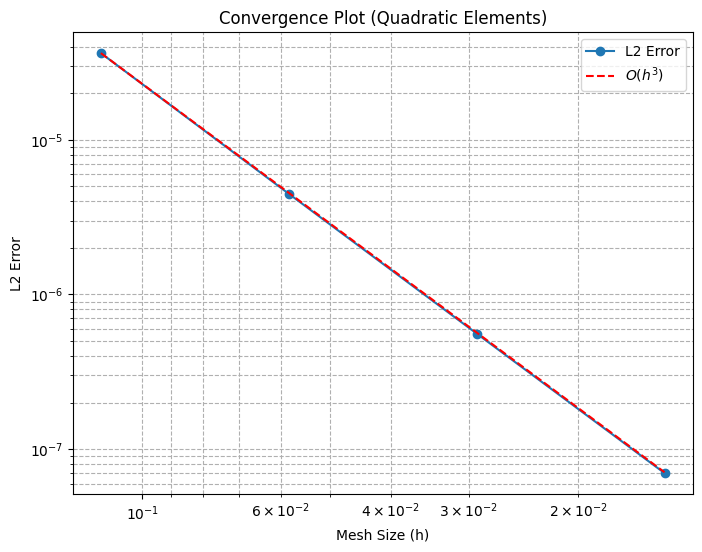


Approximate Convergence Rates (L2):
  0 -> 1: 3.02
  1 -> 2: 3.00
  2 -> 3: 3.00


In [12]:

l2_errors = []
h_values = []

# Quadrature points for L2 error calculation (use the same as assembly)
xi_q = np.array([1 / 3, 0.797426985353087, 0.101286507323456, 0.101286507323456,
                 0.059715871789770, 0.470142064105115, 0.470142064105115])
eta_q = np.array([1 / 3, 0.101286507323456, 0.797426985353087, 0.101286507323456,
                  0.470142064105115, 0.059715871789770, 0.470142064105115])
w_q = np.array([0.1125, 0.062969590272413, 0.062969590272413, 0.062969590272413,
                0.066197076394253, 0.066197076394253, 0.066197076394253])  # Weights for area=0.5

for ref in range(0, 4):  # Increased range for better convergence plot

    V_base = np.loadtxt('mesh.v')
    E_base = np.loadtxt('mesh.e', dtype=int)

    # refine mesh
    t = tri.Triangulation(V_base[:, 0], V_base[:, 1], E_base)
    if ref > 0:  # Don't refine for ref=0
        mesh = tri.UniformTriRefiner(t)
        t = mesh.refine_triangulation(subdiv=ref)
    V = np.vstack([t.x, t.y]).T
    E = t.triangles
    print(f"Refinement: {ref}, V.shape: {V.shape}, E.shape: {E.shape}")

    # Estimate mesh size h (e.g., max edge length or sqrt(avg_area))
    # Using average edge length for simplicity
    edge_lengths = []
    for el in E:
        p0, p1, p2 = V[el[0]], V[el[1]], V[el[2]]
        edge_lengths.append(np.linalg.norm(p1 - p0))
        edge_lengths.append(np.linalg.norm(p2 - p1))
        edge_lengths.append(np.linalg.norm(p0 - p2))
    h = np.mean(edge_lengths)  # Use average edge length as h
    h_values.append(h)

    V2, E2, edges2 = generate_quadratic(V, E, return_edges=True)
    X, Y = V2[:, 0], V2[:, 1]
    # plt.triplot(X, Y, E2[:, :3])
    # plt.show()

    # --- Re-assemble and solve on the refined mesh ---
    ne = E2.shape[0]
    nv = V2.shape[0]
    m = 6  # Quadratic elements

    AA = np.zeros((ne, m ** 2))
    IA = np.zeros((ne, m ** 2), dtype=int)
    JA = np.zeros((ne, m ** 2), dtype=int)
    bb = np.zeros((ne, m))
    ib = np.zeros((ne, m), dtype=int)
    jb = np.zeros((ne, m), dtype=int)

    for ei in range(0, ne):
        K = E2[ei, :]
        x0, y0 = X[K[0]], Y[K[0]]
        x1, y1 = X[K[1]], Y[K[1]]
        x2, y2 = X[K[2]], Y[K[2]]

        J = np.array([[x1 - x0, x2 - x0], [y1 - y0, y2 - y0]])
        invJ = np.linalg.inv(J.T)
        detJ = np.linalg.det(J)

        Aelem = np.zeros((m, m))
        belem = np.zeros((m,))

        for w, xi, eta in zip(w_q, xi_q, eta_q):
            zeta = 1 - xi - eta
            basis = np.array([zeta * (2 * zeta - 1), xi * (2 * xi - 1), eta * (2 * eta - 1),
                              4 * xi * zeta, 4 * xi * eta, 4 * eta * zeta])
            dbasis = np.array([[4 * xi + 4 * eta - 3, 4 * xi - 1, 0, 4 - 8 * xi - 4 * eta, 4 * eta, -4 * eta],
                               [4 * xi + 4 * eta - 3, 0, 4 * eta - 1, -4 * xi, 4 * xi, 4 - 4 * xi - 8 * eta]])
            dphi = invJ.dot(dbasis)
            xt, yt = J.dot(np.array([xi, eta])) + np.array([x0, y0])
            kappaelem = kappa(xt, yt)
            Aelem += w * kappaelem * (dphi.T @ dphi) * detJ
            belem += w * f(xt, yt) * basis * detJ

        AA[ei, :] = Aelem.ravel()
        IA[ei, :] = np.repeat(K, m)
        JA[ei, :] = np.tile(K, m)
        bb[ei, :] = belem.ravel()
        ib[ei, :] = K
        jb[ei, :] = 0

    A = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())), shape=(nv, nv))
    A.sum_duplicates()
    b = sparse.coo_matrix((bb.ravel(), (ib.ravel(), jb.ravel())), shape=(nv, 1)).toarray().ravel()

    # --- Apply Boundary Conditions ---
    tol = 1e-14
    # Find boundary nodes on the quadratic mesh V2
    boundary_nodes = np.where((np.abs(X + 1) < tol) | (np.abs(X - 1) < tol) |
                              (np.abs(Y + 1) < tol) | (np.abs(Y - 1) < tol))[0]
    boundary_nodes = np.unique(boundary_nodes)

    # Efficiently modify COO data before conversion to CSR/CSC
    keep = np.ones(A.data.shape, dtype=bool)
    new_data = A.data.copy()
    new_rows = A.row.copy()
    new_cols = A.col.copy()

    # Identify rows/cols corresponding to boundary nodes
    row_is_bc = np.isin(A.row, boundary_nodes)
    col_is_bc = np.isin(A.col, boundary_nodes)

    # Zero out off-diagonal entries connected to BC nodes
    keep[row_is_bc & (A.row != A.col)] = False
    keep[col_is_bc & (A.row != A.col)] = False

    # Set diagonal entries for BC nodes to 1
    diag_indices = (A.row == A.col) & row_is_bc
    new_data[diag_indices] = 1.0
    keep[diag_indices] = True  # Ensure diagonals are kept

    # Filter COO arrays
    A = sparse.coo_matrix((new_data[keep], (new_rows[keep], new_cols[keep])), shape=(nv, nv))
    A.sum_duplicates()  # Consolidate potential duplicate entries

    # Modify RHS: set b[i] = u_exact(X[i], Y[i]) for boundary nodes i
    # For zero Dirichlet BC, set b[i] = 0
    b[boundary_nodes] = 0.0

    # --- Solve ---
    u = sla.spsolve(A.tocsr(), b)

    # --- Compute L2 error ||u - uexact|| ---
    # L2_error^2 = sum_elements( integral_element( (u_h - u_exact)^2 dx dy ) )
    l2_err_sq = 0.0
    for ei in range(0, ne):
        K = E2[ei, :]  # Quadratic element node indices
        u_elem = u[K]  # Local solution values at nodes

        x0, y0 = X[K[0]], Y[K[0]]
        x1, y1 = X[K[1]], Y[K[1]]
        x2, y2 = X[K[2]], Y[K[2]]

        J = np.array([[x1 - x0, x2 - x0], [y1 - y0, y2 - y0]])
        detJ = np.linalg.det(J)

        # Integrate over the element using quadrature
        for w, xi, eta in zip(w_q, xi_q, eta_q):
            zeta = 1 - xi - eta
            # Calculate basis functions at quadrature point
            basis = np.array([zeta * (2 * zeta - 1), xi * (2 * xi - 1), eta * (2 * eta - 1),
                              4 * xi * zeta, 4 * xi * eta, 4 * eta * zeta])

            # Calculate u_h at quadrature point
            u_h_q = basis @ u_elem

            # Calculate physical coordinates of quadrature point
            xt, yt = J.dot(np.array([xi, eta])) + np.array([x0, y0])

            # Calculate u_exact at quadrature point
            u_exact_q = uexact(xt, yt)

            # Add contribution to L2 error squared
            l2_err_sq += w * (u_h_q - u_exact_q) ** 2 * detJ  # w includes 0.5 area factor

    l2_err = np.sqrt(l2_err_sq)
    l2_errors.append(l2_err)
    print(f"Refinement: {ref}, h: {h:.4e}, L2 Error: {l2_err:.4e}")

# Plot error vs mesh-size. Please label the axes clearly.
plt.figure(figsize=(8, 6))
plt.loglog(h_values, l2_errors, 'o-', label='L2 Error')

# Add reference lines for expected convergence rate O(h^3) for quadratic elements
if len(h_values) > 1:
    C = l2_errors[0] / (h_values[0] ** 3)
    plt.loglog(h_values, C * np.array(h_values) ** 3, 'r--', label=r'$O(h^3)$')

plt.xlabel('Mesh Size (h)')
plt.ylabel('L2 Error')
plt.title('Convergence Plot (Quadratic Elements)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.gca().invert_xaxis()  # Typically h decreases, so plot from large h to small h
plt.show()

# Calculate approximate convergence rate
if len(h_values) > 1:
    rates = np.log(np.array(l2_errors[:-1]) / np.array(l2_errors[1:])) / \
            np.log(np.array(h_values[:-1]) / np.array(h_values[1:]))
    print("\nApproximate Convergence Rates (L2):")
    for i, rate in enumerate(rates):
        print(f"  {ref - len(rates) + i} -> {ref - len(rates) + i + 1}: {rate:.2f}")
